In [44]:
import cv2
import glob
import tensorflow as tf
import numpy as np
import pickle
import os
import numpy as np

In [82]:
# image related data
images_name = []
images_list = []
images_features = {}
img_features_path = os.path.join('../dataset/pkl/train2048.pkl')

# caption related data
captions_list = []
captions_mapped = {}
vocab = {}
vocab_path = os.path.join('../dataset/pkl/vocab.pkl')


# encode model for preprocessing
x = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')
encode_model = tf.keras.models.Model(x.input, x.layers[-2].output)

In [83]:
path = '../dataset/images/Flicker8k_Dataset/*.jpg'

if not os.path.exists(img_features_path):
    for img in glob.glob(path):
        # reading image
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (299,299))
        images_list.append(image)
        # saving image name
        name = img.split('/')[-1]
        images_name.append(name)
        # passing image to model
        i = image.reshape(1,299,299,3)
        i = encode_model.predict(i)
        i = np.reshape(i, 2048)
        images_features[name] = i

    with open(img_features_path, 'wb') as f:
        pickle.dump(images_features, f)
else:
    print('File already exist, opening...')
    with open(img_features_path, 'rb') as f:
        images_features = pickle.load(f)
        
        for img in glob.glob(path):
            name = img.split('/')[-1]
            images_name.append(name)
    

In [84]:
f = open('../dataset/text/Flickr8k.token.txt', 'rb')
captions_list = f.read().decode('utf-8').split('\n')


for i in captions_list:
    name = i.split('\t')[0][:-2]
    caption = i.split('\t')[1]
    caption = caption.lower()
    caption = 'sequencestart ' + caption + ' sequenceend'
    if name in images_name:
        if name not in captions_mapped:
            captions_mapped[name] = [caption]
        else:
            captions_mapped[name].append(caption)

In [85]:
mapped_number = 1
for w in captions_mapped.values():
    for words in w:
        for word in words.split():
            if word not in vocab:
                vocab[word] = mapped_number
                mapped_number += 1

for i, w in captions_mapped.items():
    for words in w:
        mapped = []
        for word in words.split():
            mapped.append(vocab[word])

        captions_mapped[i][w.index(words)] = mapped
        
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

if not os.path.exists(vocab_path):
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab, f)

In [ ]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

In [86]:
MAX_LEN = 0
for img_name, captions in captions_mapped.items():
    for caption in captions:
        if len(caption) > MAX_LEN:
            MAX_LEN = len(caption)

In [87]:
def create_seq(captions, photo):
    X1, X2, y = [], [], []
    for caption in captions:
        for i in range(1, len(caption)):
            in_seq, out_seq = caption[:i], caption[i]

            in_seq = tf.keras.preprocessing.sequence.pad_sequences(
                [in_seq], 
                maxlen=MAX_LEN)[0]

            out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=len(vocab))[0]
            
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [88]:
def generator():
    while True:
        for img_name, caption in captions_mapped.items():
            img = images_features[img_name]
            x1, x2, y = create_seq(caption, img)
            yield [x1, x2], y

In [89]:
def architecture():
    # creating feature extractor model
    feature_model_input =  tf.keras.layers.Input(shape=(2048,), name='feature_input')
    feature_model_dropout = tf.keras.layers.Dropout(0.5)(feature_model_input)
    feature_model_dense = tf.keras.layers.Dense(256, activation='relu')(feature_model_dropout)

    # creating recurrent model
    recurrent_model_input = tf.keras.layers.Input(shape=(MAX_LEN,), name='r_input')
    recurrent_model_embedding = tf.keras.layers.Embedding(len(vocab), 256, mask_zero=True)(recurrent_model_input)
    recurrent_model_dropout = tf.keras.layers.Dropout(0.5)(recurrent_model_embedding)
    recurrent_model_lstm = tf.keras.layers.LSTM(256)(recurrent_model_dropout)

    # adding models 
    added_model = tf.keras.layers.add([feature_model_dense, recurrent_model_lstm])
    added_model_dense = tf.keras.layers.Dense(256, activation='relu')(added_model)
    output = tf.keras.layers.Dense(len(vocab), activation='softmax')(added_model_dense)

    # creating keras model object
    model = tf.keras.models.Model(inputs=[feature_model_input, recurrent_model_input], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

In [90]:
# train the model, run epochs manually and save after each epoch
model = architecture()
epochs = 20
steps = len(captions_mapped)//3
for i in range(epochs):
	# create the data generator
	gen = generator()
	# fit for one epoch
	model.fit_generator(gen, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	model.save('2_model_' + str(i) + '.h5')

 660/2697 [======>.......................] - ETA: 6:09 - loss: 3.4731

KeyboardInterrupt: 

In [94]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
r_input (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
feature_input (InputLayer)      [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 40, 256)      2283520     r_input[0][0]                    
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 2048)         0           feature_input[0][0]              
___________________________________________________________________________________________

In [91]:
# generate caption
def exctract_img_features(img):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (299,299))
    image = np.reshape(image, (1,299,299,3))
    features = encode_model.predict(image)
    return features

def word_by_token(value):
    for word, index in vocab.items():
        if index == value:
            return word
    return None

def generate_caption(model, img):
    text = ['sequencestart']
    caption = ' '

    for i in range(MAX_LEN):
        encoded = []
        for t in text:
            encoded.append(vocab[t])

        encoded = tf.keras.preprocessing.sequence.pad_sequences([encoded], maxlen=MAX_LEN)
        pred = model.predict([img, encoded], verbose=0)
        pred = np.argmax(pred)

        word = word_by_token(pred)

        if word  == 'sequenceend':
            break
        
        caption += ' ' + str(word)
        text.append(word)

    return caption

In [93]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(model):
	actual, predicted = list(), list()
	# step over the whole set
	for k, v in captions_mapped.items():
		# generate description
		yhat = generate_caption(model, images_features[k].reshape(1, 2048))
		# store actual and predicted
		references = [d.split() for d in v]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

    
model = tf.keras.models.load_model('../src/2_model_1.h5')
evaluate_model(model)

AttributeError: 'list' object has no attribute 'split'

Text(0.5, 0, '  a man in a red shirt is running through the water .')

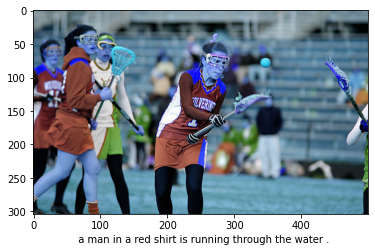

In [41]:
import matplotlib.pyplot as plt
path = '../dataset/images/Flicker8k_Dataset/123997871_6a9ca987b1.jpg'
model = tf.keras.models.load_model('../src/2_model_1.h5')
i = exctract_img_features(path)
caption = generate_caption(model, i)
image = cv2.imread(path)
plt.imshow(image)
plt.xlabel(caption)